In [100]:
#Import necessary  libraries
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
import librosa.display
import os
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
import cv2
import os
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import vgg16

from keras.callbacks import ModelCheckpoint, EarlyStopping

#glob used to return all file paths that match a specific pattern
from glob import glob

### Path for  audio files


In [101]:
def files(db,machine,type_machine):
    files = []
    for i in range(0,7,2):
        data_dir = f"Audio_Files/{db}dB_{machine}/id_0{i}/{type_machine}"
        files += glob(data_dir + '/*.wav')  
    return files


In [102]:
# 0_db_normal_fan

o_db_normal_fan = files(0,'fan','normal')

# 0_db_abnormal_fan

o_db_abnormal_fan = files(0,'fan','abnormal')

# 6_db_normal_fan

p6_db_normal_fan = files(6,'fan','normal')

# 6_db_abnormal_fan

p6_db_abnormal_fan = files(6,'fan','abnormal')

# -6_db_normal_fan

min6_db_normal_fan = files(-6,'fan','normal')

# -6_db_abnormal_fan

min6_db_abnormal_fan = files(-6,'fan','abnormal')


### Get all normal files

In [103]:
normal_fan = p6_db_normal_fan + o_db_normal_fan + min6_db_normal_fan

### Get all abnormal files

In [19]:
abnormal_fan = p6_db_abnormal_fan + o_db_abnormal_fan + min6_db_abnormal_fan

In [27]:
len(abnormal_fan)

4425

### Get .png 

In [104]:
def to_png(files,directory,name_file):    

    for i in range(len(files)):
        data, sr = librosa.load(files[i])
        data = scale(data)
       
        countstr = str(i)

        melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)
           
        log_melspec = librosa.power_to_db(melspec, ref=np.max)  
        librosa.display.specshow(log_melspec, sr=sr)
            
        
      
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        png_number= name_file + countstr  


        plt.savefig(directory + '/' + (png_number) + '.png')            
    
    return 0

In [ ]:
# save normal fan to .png
to_png(normal_fan,'Normal','normal_')

In [ ]:
# save abnormal fan to .png
to_png(abnormal_fan,'Abnormal','abnormal_')

In [45]:
data, sr = librosa.load(normal_fan[1])

In [46]:
data

array([0.00675145, 0.00731525, 0.00562506, ..., 0.00300432, 0.00412645,
       0.00288242], dtype=float32)

In [47]:
data = scale(data)

In [48]:
data

array([1.4734191, 1.5965308, 1.2274562, ..., 0.6551872, 0.9002181,
       0.628569 ], dtype=float32)

In [49]:
melspec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128)

In [50]:
type(melspec)

numpy.ndarray

In [51]:
melspec.shape

(128, 431)

### Data set path

In [27]:
size = (432,288,3)

# for train data
train_path = './train'
#for test data 
test_path = './test'


batch_size =16

### Load images

In [28]:
def load_images(path):
    
    images = []
    for file in os.listdir(path):
        img = cv2.imread(os.path.join(path,file))
        if img is not None:
            images.append(img)
    
    plt.figure(figsize=(15,8))    
    for img,x in zip(images,range(1,7)):
        plt.subplot(2,3,x)
        plt.imshow(img)

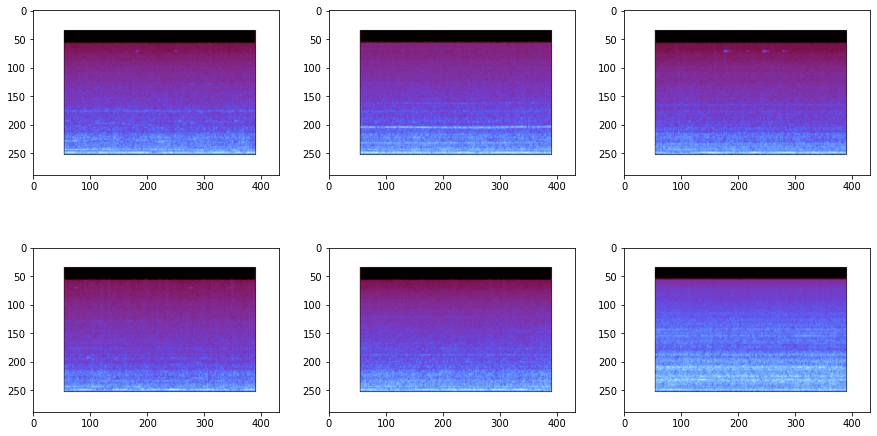

In [29]:
train_normal = './train/Normal'

load_images(train_normal)

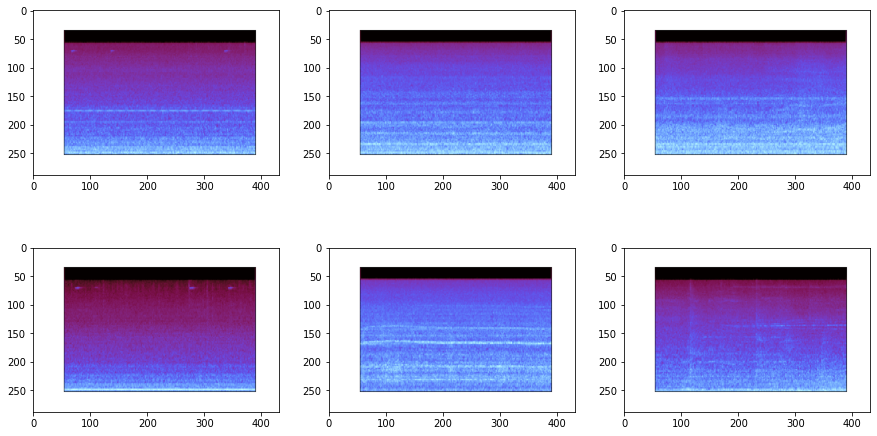

In [30]:
train_abnormal = './train/Abnormal'

load_images(train_abnormal)

### Data Generator

In [31]:
# Image Data Generator for train set

train_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

# Image Data Generator for test set

test_gen = ImageDataGenerator(
        validation_split=0.3, rescale=1/255
)

In [32]:
train = train_gen.flow_from_directory(
            train_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'training'
)

test = test_gen.flow_from_directory(
            test_path,
            target_size = (size[0], size[1]),
            batch_size = batch_size,
            class_mode = 'categorical',
            shuffle = True,
            subset = 'validation'
)

Found 3282 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [13]:
test_num = test.samples

label_test = []
for i in range((test_num // test.batch_size)+1):
    X,y = test.next()
    label_test.append(y)
        
label_test = np.argmax(np.vstack(label_test), axis=1)

### Create Model Function

In [83]:
def create_model():
    
    model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = size)

    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation="softmax")(x)
    
    model = Model(model.input, x)
    model.compile(loss = "categorical_crossentropy", 
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["acc"])
    model.summary()
    
    return model

### Save Model - Callbacks

In [86]:
#save the model
checkpoint_path = "mel.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# create callbacks with check point
callbacks = [EarlyStopping(monitor='acc', patience=22, verbose=1, mode='auto'),
             ModelCheckpoint(checkpoint_path, monitor='acc', 
             save_best_only=True, save_weights_only=False, mode='auto')]

### Fit Model

In [87]:
model = create_model()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 432, 288, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 432, 288, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 432, 288, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 216, 144, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 216, 144, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 216, 144, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 108, 72, 128)      0   

In [88]:
steps_per_epoch= train.samples/train.batch_size

In [89]:
steps_per_epoch

205.125

In [90]:
history = model.fit(train, steps_per_epoch= 100, validation_data= test,
                           epochs= 9, callbacks= callbacks)

Epoch 1/9
100/100 [==============================] - 1552s 16s/step - loss: 0.6937 - acc: 0.5244 - val_loss: 0.6909 - val_acc: 0.5000
Epoch 2/9
100/100 [==============================] - 1669s 17s/step - loss: 0.6900 - acc: 0.5306 - val_loss: 0.6889 - val_acc: 0.5000
Epoch 3/9
100/100 [==============================] - 1862s 19s/step - loss: 0.6835 - acc: 0.5587 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 4/9
100/100 [==============================] - 1845s 18s/step - loss: 0.6768 - acc: 0.5952 - val_loss: 0.6886 - val_acc: 0.5000
Epoch 5/9
100/100 [==============================] - 1864s 19s/step - loss: 0.6630 - acc: 0.6631 - val_loss: 0.6558 - val_acc: 0.6755
Epoch 6/9
100/100 [==============================] - 1844s 18s/step - loss: 0.6387 - acc: 0.7465 - val_loss: 0.6210 - val_acc: 0.8298
Epoch 7/9
100/100 [==============================] - 1835s 18s/step - loss: 0.5859 - acc: 0.7787 - val_loss: 0.5637 - val_acc: 0.7340
Epoch 8/9
100/100 [==============================] - 1565s 16s

### Classification Report


In [91]:
print(classification_report(label_test, np.argmax(model.predict(test),axis=1)))


              precision    recall  f1-score   support

           0       0.45      0.43      0.44        94
           1       0.45      0.48      0.47        94

    accuracy                           0.45       188
   macro avg       0.45      0.45      0.45       188
weighted avg       0.45      0.45      0.45       188



### Plot Model

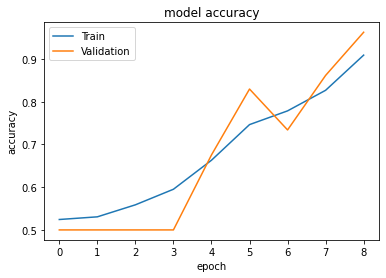

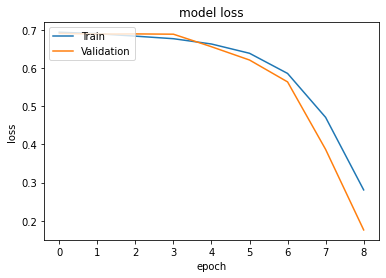

In [92]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Prediction

In [113]:
def predict(path):

    img = image.load_img(path, target_size=(432, 288))
    
    # Preprocessing the image
    pp_img = image.img_to_array(img)
    pp_img = pp_img/255
    pp_img = np.expand_dims(pp_img, axis=0)
    
    #Load Model
    saved_model = load_model("mel.h5")

    #predict
    img_pred= saved_model.predict(pp_img)
    
    
    if img_pred[0][0] >= 0.5: 
        pred = ('Abnormal : {:%} percent'.format(img_pred[0][0]))
    
    else: 
        pred = ('Normal : {:%} percent'.format(1- img_pred[0][0]))
        
    plt.title("Anomaly Detection\n"+ pred)  

    plt.imshow(np.squeeze(pp_img))
    
    return  plt.show()

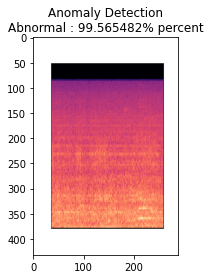

In [93]:
path = 'test/Abnormal/abnormal_1962.png'
predict(path)

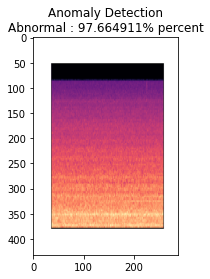

In [119]:
path = 'test/Abnormal/abnormal_1970.png'
predict(path)

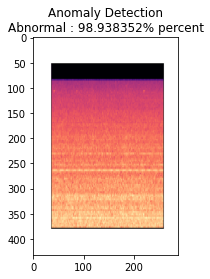

In [118]:
path = 'test/Abnormal/abnormal_1972.png'
predict(path)

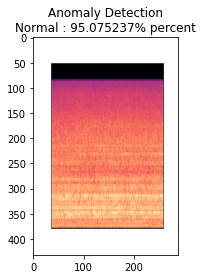

In [117]:
path = 'test/Normal/normal_1370.png'
predict(path)

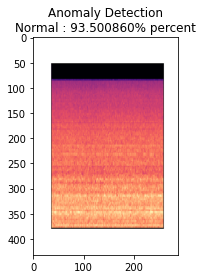

In [116]:
path = 'test/Normal/normal_1374.png'
predict(path)

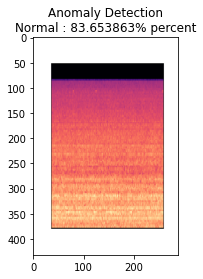

In [115]:
path = 'test/Normal/normal_1431.png'
predict(path)

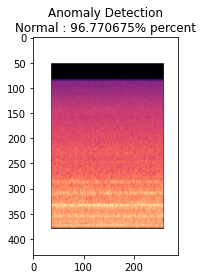

In [114]:
path = 'Nrmal/normal_3016.png'
predict(path)